In [1]:
import pygrib as pg
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os
import datetime
import pyproj

0.0

In [2]:
ndfd_file = pathlib.Path('../sampleinputs/torn_day1_grib2_1630_20190520162619')

In [3]:
with pg.open(ndfd_file.as_posix()) as GRB:
    try:
        vals = GRB[1].values.filled(-1)
    except:
        vals = GRB[1].values

In [4]:
ndfd_cat_file = pathlib.Path('../sampleinputs/cat_day1_grib2_1630_20190520162619')

In [5]:
with pg.open(ndfd_cat_file.as_posix()) as GRB:
    try:
        cat = GRB[1].values.filled(-1)
    except:
        cat = GRB[1].values

In [6]:
with pg.open(ndfd_file.as_posix()) as GRB:
    lats,lons = GRB[1].latlons()
    lats,lons = np.array(lats),np.array(lons)

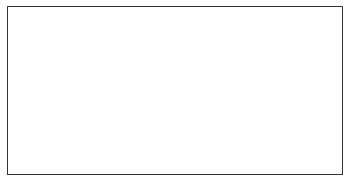

In [7]:
ax1 = plt.axes(projection=ccrs.PlateCarree())

In [8]:
ax1.coastlines()

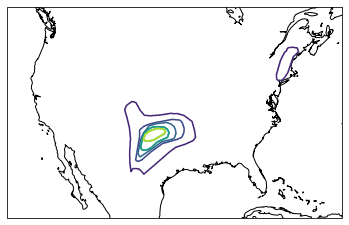

In [9]:
ax1 = plt.axes(projection=ccrs.LambertConformal())
ax1.coastlines()
ax1.contour(lons, lats, vals,transform=ccrs.PlateCarree())
#plt.show()

## Making continuous probs

In [6]:
from skimage import measure
from scipy import interpolate as I

In [7]:
torn = vals

In [8]:
def make_continuous(probs):
    vals = [1, 2, 5, 10, 15, 30, 45, 60]
    continuous = np.zeros_like(probs)
    contours = [measure.find_contours(probs, v-1e-10) for v in vals]
    for tcontours, val in zip(contours, vals):
        for contour in tcontours:
            x, y = zip(*contour.astype(int))
            continuous[x, y] = val
    continuous = interpolate(continuous).astype(int, copy=False)
    continuous[probs < vals[0]] = 0
    return continuous

In [9]:
def interpolate(image):
    valid_mask = image > 0
    coords = np.array(np.nonzero(valid_mask)).T
    values = image[valid_mask]
    INTERP = I.LinearNDInterpolator(coords, values, fill_value=0)
    new_image = INTERP(list(np.ndindex(image.shape))).reshape(image.shape)
    return new_image

In [10]:
cont = make_continuous(torn)

In [11]:
probvals = [1, 2, 5, 10, 15, 30, 45, 60]
continuous = np.zeros_like(torn)
contours = [measure.find_contours(torn, v-1e-10) for v in probvals]

## Distributions

In [13]:
from scipy import stats

In [50]:
y = stats.exponweib(13.12425, 0.50321, loc=0, scale=1.73468e-5)

In [62]:
x = np.linspace(0,0.001, 1000)

/Users/josephpicca/anaconda/envs/impacts/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1678: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


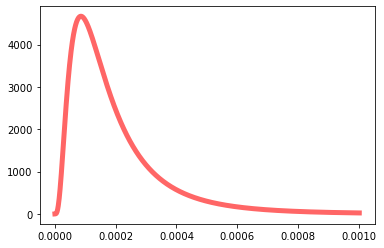

In [65]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, stats.exponweib.pdf(x,13.12425, 0.50321, loc=0, scale=1.73468e-5),'r-', lw=5, alpha=0.6, label='weibull pdf')

In [147]:
imGrids = np.load('../impacts-data/pas-input-data/impact-grids.npz')

In [158]:
projStr = imGrids['srs'].item()
projStr

'+units=m +proj=lcc +lon_0=265 +lat_0=25 +lat_1=25 +lat_2=25 +a=6371200 +b=6371200 '

In [155]:
proj = pyproj.Proj(projStr)
proj.srs

'+proj=lcc +lat_0=25 +lon_0=265 +lat_1=25 +lat_2=25 +x_0=0 +y_0=0 +R=6371200 +units=m +no_defs'

In [154]:
pyproj.Geod(proj.srs)

KeyError: 'a'

But this works...

In [157]:
pyproj.Geod(imGrids['srs'].item())

Geod('+a=6371200 +f=0')

In [145]:
#pyproj.Proj(ospedale['srs'].item()).srs
ospedale['srs'].item()

'+units=m +proj=lcc +lon_0=265 +lat_0=25 +lat_1=25 +lat_2=25 +a=6371200 +b=6371200 '

In [146]:
ospedale.files
pyproj.Geod('+units=m +proj=lcc +lon_0=265 +lat_0=25 +lat_1=25 +lat_2=25 +a=6371200 +b=6371200')

Geod('+a=6371200 +f=0')

# Walking through entirety of simulation

Arguments

In [14]:
ndfd_file = pathlib.Path('/Users/josephpicca/Downloads/ds.ptornado (1).bin')
ndfd_area = 25
nsims = 10000
tornado_direction_distribution = stats.norm(50,15)
coolseason = [1,2,3,4,11,12]

In [15]:
os.environ['IMPACTSDATA'] = "../impacts-data"
impacts_data_root = pathlib.Path(os.environ['IMPACTSDATA'],"pas-input-data").expanduser().resolve()

In [17]:
outdir = pathlib.Path('..','..','output').resolve()
outdir.mkdir(exist_ok=True)

In [18]:
#date_in_name = ndfd_file.name.split("_")[-1]
#dt = datetime.datetime.strptime(date_in_name, "%Y%m%d%H%M%S")
#outfile = outdir.joinpath(f"{dt.strftime('%Y%m%d%H%M')}.psv.gz")
outfile = outdir.joinpath("today.psv.gz")

In [19]:
def read_ndfd_grib_file(grbfile):
    """ Read an SPC Outlook NDFD Grib2 File """
    with pg.open(grbfile.as_posix()) as GRB:
        try:
            vals = GRB[1].values.filled(-1)
        except AttributeError:
            vals = GRB[1].values
    return vals

Read tornado/cat files

In [20]:
torn = read_ndfd_grib_file(ndfd_file)
continuous_torn = make_continuous(torn)

In [22]:
# Read/Create Single and Double Sig Grids
#sigtorn = read_ndfd_grib_file(ndfd_file.with_name(ndfd_file.name.replace("torn", "sigtorn"))).astype(int)
sigtorn = read_ndfd_grib_file(pathlib.Path('/Users/josephpicca/Downloads/ds.pxtornado.bin'))
sigtorn[sigtorn > 0] = 1
if (torn.max() >= 30) and (sigtorn.max() > 0):
    sigtorn[torn >= 15] += 1
sigtorn_1d = sigtorn.ravel()
usesig = True #if (dt.month in coolseason) or (sigtorn.max() > 0) else False

Run tornado count simulation

In [24]:
### Run Tornado Count Simulation ###
print(f"Running {nsims:,d} Tornado Count Simulations")
tornado_dists = TornadoDistributions()
counts = np.zeros((5, nsims), dtype=int)
counts[0, :] = (tornado_dists.f02.rvs(nsims) * ndfd_area * (torn == 2).sum()).astype(int)
counts[1, :] = (tornado_dists.f05.rvs(nsims) * ndfd_area * (torn == 5).sum()).astype(int)
counts[2, :] = (tornado_dists.f10.rvs(nsims) * ndfd_area * (torn == 10).sum()).astype(int)
counts[3, :] = (tornado_dists.f15.rvs(nsims) * ndfd_area * (torn == 15).sum()).astype(int)
counts[4, :] = (tornado_dists.f30.rvs(nsims) * ndfd_area * (torn >= 30).sum()).astype(int)

Running 10,000 Tornado Count Simulations


In [193]:
### Setup Impact Simulation ###
igrids = dc.ImpactGrids(impacts_data_root)

# Determine the indices of tornadoes for each prob level
scounts = counts.sum(axis=1)
inds02 = dc.weighted_choice(prob=2, probs=torn, cprobs=continuous_torn, size=scounts[0])
inds05 = dc.weighted_choice(prob=5, probs=torn, cprobs=continuous_torn, size=scounts[1])
inds10 = dc.weighted_choice(prob=10, probs=torn, cprobs=continuous_torn, size=scounts[2])
inds15 = dc.weighted_choice(prob=15, probs=torn, cprobs=continuous_torn, size=scounts[3])
inds30 = dc.weighted_choice(prob=30, probs=torn, cprobs=continuous_torn, size=scounts[4])
inds = dc.flatten_list([inds02, inds05, inds10, inds15, inds30])

non_sig_inds = sigtorn_1d[inds] == 0
single_sig_inds = sigtorn_1d[inds] == 1
double_sig_inds = sigtorn_1d[inds] == 2

if usesig:
    single_sig_inds += non_sig_inds
    non_sig_inds[:] = False

# Handle Locations
non_sig_loc_inds = inds[non_sig_inds]
single_sig_loc_inds = inds[single_sig_inds]
double_sig_loc_inds = inds[double_sig_inds]

# Handle Ratings
_mags=[0, 1, 2, 3, 4, 5]
non_sig_ratings = np.random.choice(_mags, size=non_sig_inds.sum(),
                                   replace=True, p=tornado_dists.r_nonsig)
single_sig_ratings = np.random.choice(_mags, size=single_sig_inds.sum(),
                                      replace=True, p=tornado_dists.r_singlesig)
double_sig_ratings = np.random.choice(_mags, size=double_sig_inds.sum(),
                                      replace=True, p=tornado_dists.r_doublesig)

# Handle Distances
non_sig_distances = dc.get_distances(non_sig_ratings, tornado_dists)
single_sig_distances = dc.get_distances(single_sig_ratings, tornado_dists)
double_sig_distances = dc.get_distances(double_sig_ratings, tornado_dists)

#print("Running simulations...")
#print("    Non Sig...")
non_sig = dc.simulate(non_sig_loc_inds, non_sig_distances,
                      non_sig_ratings, tornado_direction_distribution, igrids)
#print("    Single Sig...")
single_sig = dc.simulate(single_sig_loc_inds, single_sig_distances,
                         single_sig_ratings, tornado_direction_distribution, igrids)
#print("    Double Sig...")
double_sig = dc.simulate(double_sig_loc_inds, double_sig_distances,
                         double_sig_ratings, tornado_direction_distribution, igrids)

#print("Splitting simulations back out...")
simulated_tornadoes = dc.flatten_list([non_sig, single_sig, double_sig])
np.random.shuffle(simulated_tornadoes)
_sims = np.split(simulated_tornadoes, counts.sum(axis=0).cumsum())[:-1]
realizations = dc.Realizations([dc.SyntheticTornadoRealization(_sim, i+1) for i, _sim in enumerate(_sims)])


#print("Writing Out gzipped PSV file...")
with gzip.GzipFile(outfile, "w") as OUT:
    OUT.write(realizations.as_psv.encode())

array([0, 1, 2, 3, 4, 5])

In [12]:
np.max(torn)

45.0

### Impact Grid

In [137]:
igrids = ImpactGrids(impacts_data_root)

KeyError: 'a'

In [111]:
np.size(counts[0])

10000

In [163]:
counts = np.zeros((5,10000),dtype=int)

In [172]:
counts[0,:] = (tornado_dists.f02.rvs(10000) * ndfd_area * (torn == 2).sum()).astype(int)
np.mean(counts[0])

4.1571

In [167]:
scounts = counts.sum(axis=1)
scounts

array([43575,     0,     0,     0,     0])

In [168]:
inds02 = weighted_choice(prob=2,probs=torn,cprobs=continuous_torn, size=scounts[0])
inds02

array([583617, 505242, 355739, ..., 185016, 514909, 256985])

In [190]:
weights = np.ma.asanyarray(continuous_torn[:])
np.size(weights)

739297

In [180]:
weights[torn > 2] = np.ma.masked
cumulative_weights = weights.cumsum()
_locs = np.random.randint(cumulative_weights.min(),cumulative_weights.max(),size=10000)

In [191]:
locs = cumulative_weights.searchsorted(_locs)
np.max(locs)

595406

In [160]:
weighted_choice(prob=2,probs=torn,cprobs=continuous_torn,size=)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

dataclasses

In [23]:
import pathlib

import numpy as np
import pyproj
from scipy import interpolate as I
from scipy import stats
from skimage import measure

import pygridder as pgrid


_fips2state = {'01': 'AL', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE',
               '11': 'DC', '12': 'FL', '13': 'GA', '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA',
               '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI',
               '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
               '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', '40': 'OK',
               '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX',
               '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV', '55': 'WI', '56': 'WY'}

_synthetic_tornado_fields = ["population", "distance", "rating", "states", 
        "counties", "wfos", "hospitals", "hospitalbeds", "mobileparks", 
        "mobilehomes", "psubstations", "plines", "slon", "slat", "elon", "elat"]

class TornadoDistributions(object):
    def __init__(self):
        # Tornado Frequencies per unit Area
        self.f02 = stats.exponweib(56.14739, 0.28515, loc=0, scale=4.41615e-8)
        self.f05 = stats.exponweib(21.21447, 0.352119, loc=0, scale=6.13437e-7)
        self.f10 = stats.exponweib(4.931, 0.559246, loc=0, scale=1.3774e-5)
        self.f15 = stats.exponweib(4.9897, 0.581757, loc=0, scale=2.09688e-5)
        self.f30 = stats.exponweib(13.12425, 0.50321, loc=0, scale=1.73468e-5)

        # Tornado Rating Distributions
        self.r_notorn = np.array([0.764045, 0.196629, 0.033708, 0.005618, 0, 0])
        self.r_nonsig = np.array([0.653056, 0.269221, 0.058293, 0.016052, 0.003378, 0])
        self.r_singlesig = np.array([0.460559, 0.381954, 0.119476, 0.031184, 0.006273, 0.000554])
        self.r_doublesig = np.array([0.3003, 0.363363, 0.168168, 0.09009, 0.063063, 0.015016])

        # Tornado Distance Distributions
        self.d_notorn = stats.exponweib(2.619664326, 0.4409500787, loc=0, scale=0.2740657129)
        self.d_nonsig = stats.exponweib(2.334887225, 0.436718339, loc=0, scale=0.4568290829)
        self.d_singlesig = stats.exponweib(2.03198642, 0.4986790369, loc=0, scale=1.2430926)
        self.d_doublesig = stats.exponweib(3.773715273, 0.3859052339, loc=0, scale=0.9866466004)
        self.d0 = stats.exponweib(1, 1, loc=0, scale=1.070527950949243)
        self.d1 = stats.exponweib(1, 1, loc=0, scale=2.711161913125773)
        self.d2 = stats.exponweib(1, 1, loc=0, scale=4.273788264405339)
        self.d3 = stats.exponweib(1, 1, loc=0, scale=5.8415587968313485)
        self.d4 = stats.exponweib(1, 1, loc=0, scale=7.156414869284822)
        self.d5 = stats.exponweib(1, 1, loc=0, scale=7.209804431404343)


class ImpactGrids(object):
    def __init__(self, impacts_grids_root):
        impacts_grids_file = impacts_grids_root.joinpath("impact-grids.npz")
        with np.load(impacts_grids_file) as NPZ:
            self.population = NPZ["population"]
            self.proj = pyproj.Proj(NPZ["srs"].item())
            self.geod = pyproj.Geod(self.proj.srs)
            self.lons = NPZ["lons"]
            self.lats = NPZ["lats"]
            self.X = NPZ["X"]
            self.Y = NPZ["Y"]
            self.dx = NPZ["dx"]
            self.dy = NPZ["dy"]
            self.state = NPZ["state"]
            self.county = NPZ["county"]
            self.wfo = NPZ["wfo"]
            self.hospitals = NPZ["hospitals"]
            self.hospitalbeds = NPZ["hbeds"]
            self.mobilehomes = NPZ["mhomes"]
            self.mobileparks = NPZ["mparks"]
            self.psubstations = NPZ["pstations"]
            self.plines = NPZ["plines"]
        self._lons1d = self.lons.ravel()
        self._lats1d = self.lats.ravel()
        self._x1d = self.X.ravel()
        self._y1d = self.Y.ravel()
        self.grid_cell_area = self.dx * self.dy
        self.grid_cell_area_kmsq = self.grid_cell_area / 1000**2
        self.gridder = pgrid.Gridder(tx=self.X, ty=self.Y, dx=max(self.dx, self.dy))


class SyntheticTornado(object):
    def __init__(self, slon, slat, elon, elat, population, distance, rating, states, counties, wfos, hospitals,
                 hospitalbeds, mobileparks, mobilehomes, psubstations, plines, loc_precision=4):
        self.slon = round(slon, loc_precision)
        self.slat = round(slat, loc_precision)
        self.elon = round(elon, loc_precision)
        self.elat = round(elat, loc_precision)
        self.population = population
        self.distance = round(distance, loc_precision)
        self.rating = rating
        self.states = ",".join(_fips2state["{:02d}".format(s)] for s in states if s not in [0])
        self.counties = ",".join(["{:5d}".format(s) for s in counties if s not in [0]])
        self.wfos = ",".join(["{:s}".format(s) for s in wfos if s not in [0, "0"]])
        self.hospitals = hospitals
        self.hospitalbeds = hospitalbeds
        self.mobileparks = mobileparks
        self.mobilehomes = mobilehomes
        self.psubstations = psubstations
        self.plines = plines

    @property
    def headers(self):
        return _synthetic_tornado_fields

    @property
    def values(self):
        vals = [self.__dict__[header] for header in self.headers]
        return vals

    @property
    def __geo_interface__(self):
        props = {h:v for h,v in zip(self.headers, self.values) if h not in ["slon", "slat", "elon", "elat"]}
        coords = [(self.slon, self.slat), (self.elon, self.elat)]
        base = {"type": "LineString", "coordinates": tuple(coords)}
        return {"type": "Feature", "geometry": base, "properties": props}


class SyntheticTornadoRealization(object):
    def __getitem__(self, idx):
        return self.tornadoes[idx]

    def __init__(self, tornadoes, number):
        self.sim_number = number
        self.tornadoes = tornadoes
        self.number_of_tornadoes = sum(1 for s in self.tornadoes)
        self.population = sum(s.population for s in self.tornadoes)
        self.hospitals = sum(s.hospitals for s in self.tornadoes)
        self.hospitalbeds = sum(s.hospitalbeds for s in self.tornadoes)
        self.mobileparks = sum(s.mobileparks for s in self.tornadoes)
        self.mobilehomes = sum(s.mobilehomes for s in self.tornadoes)
        self.psubstations = sum(s.psubstations for s in self.tornadoes)
        self.plines = sum(s.plines for s in self.tornadoes)

    @property
    def __geo_interface__(self):
        return {"type": "FeatureCollection", "features": [s.__geo_interface__ for s in self]}


class Realizations(object):
    def __getitem__(self, idx):
        return self.realizations[idx]

    def __init__(self, realizations):
        self.realizations = realizations

    @property
    def as_psv(self):
        header = f"sim|{'|'.join(_synthetic_tornado_fields)}"
        values = []
        for realization in self:
            for st in realization:
                v = ("|".join(str(v) for v in st.values))
                values.append(f"{str(realization.sim_number)}|{v}")
        values = "\n".join(values)
        return f"{header}\n{values}"


def get_distances(ratings, distribution):
    dists = np.zeros(ratings.shape, dtype=float)
    f0 = ratings == 0
    f1 = ratings == 1
    f2 = ratings == 2
    f3 = ratings == 3
    f4 = ratings == 4
    f5 = ratings == 5
    dists[f0] = distribution.d0.rvs(size=f0.sum())
    dists[f1] = distribution.d1.rvs(size=f1.sum())
    dists[f2] = distribution.d2.rvs(size=f2.sum())
    dists[f3] = distribution.d3.rvs(size=f3.sum())
    dists[f4] = distribution.d4.rvs(size=f4.sum())
    dists[f5] = distribution.d5.rvs(size=f5.sum())
    return dists


def simulate(inds, dists, ratings, direction, igrids):
    if inds.shape[0] < 1:
        return []
    slons = igrids._lons1d[inds]
    slats = igrids._lats1d[inds]
    slons += np.random.uniform(-0.05, 0.05, size=slons.shape[0])
    slats += np.random.uniform(-0.05, 0.05, size=slats.shape[0])
    dirs = direction.rvs(inds.shape[0])
    dists_meters = dists * 1609.34
    elons, elats, _ = igrids.geod.fwd(slons, slats, dirs, dists_meters)
    x1s, y1s = igrids.proj(slons, slats)
    x2s, y2s = igrids.proj(elons, elats)
    idxs = igrids.gridder.grid_lines(x1s, y1s, x2s, y2s)
    return [SyntheticTornado(slons[i], slats[i], elons[i], elats[i], int(igrids.population[idx].sum()),
                             float(dists[i]), int(ratings[i]), np.unique(
                                 igrids.state[idx]).tolist(),
                             np.unique(igrids.county[idx]).tolist(), np.unique(
                                 igrids.wfo[idx]).tolist(),
                             int(igrids.hospitals[idx].sum()), int(
                                 igrids.hospitalbeds[idx].sum()),
                             int(igrids.mobileparks[idx].sum()), int(
                                 igrids.mobilehomes[idx].sum()),
                             int(igrids.psubstations[idx].sum()), int(igrids.plines[idx].sum()))
            for i, idx in enumerate(idxs)]


def make_continuous(probs):
    vals = [1, 2, 5, 10, 15, 30, 45, 60]
    continuous = np.zeros_like(probs)
    contours = [measure.find_contours(probs, v-1e-10) for v in vals]
    for tcontours, val in zip(contours, vals):
        for contour in tcontours:
            x, y = zip(*contour.astype(int))
            continuous[x, y] = val
    continuous = interpolate(continuous).astype(int, copy=False)
    continuous[probs < vals[0]] = 0
    return continuous


def interpolate(image):
    valid_mask = image > 0
    coords = np.array(np.nonzero(valid_mask)).T
    values = image[valid_mask]
    INTERP = I.LinearNDInterpolator(coords, values, fill_value=0)
    new_image = INTERP(list(np.ndindex(image.shape))).reshape(image.shape)
    return new_image


def weighted_choice(prob, probs, cprobs, size):
    weights = np.ma.asanyarray(cprobs[:])
    if prob >= 30:
        weights[probs < prob] = np.ma.masked
    elif prob <= 2:
        weights[probs > prob] = np.ma.masked
    else:
        weights[probs != prob] = np.ma.masked
    cumulative_weights = weights.cumsum()
    if np.ma.is_masked(cumulative_weights.max()):
        locs = []
    else:
        _locs = np.random.randint(
            cumulative_weights.min(), cumulative_weights.max(), size=size)
        locs = cumulative_weights.searchsorted(_locs)
    return locs


def flatten_list(_list):
    return np.array([item for sublist in _list for item in sublist])
